In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )
source("script/colors.R"    )


In [2]:
dir.create("pipeline/4.10.diffexp_eclip_enrichment"    , showWarnings = FALSE)
dir.create("pipeline/4.10.diffexp_eclip_enrichment/tmp", showWarnings = FALSE)


In [3]:
geneinfo_genes    = fread("pipeline/1.2.expression/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_isoforms = fread("pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)


In [11]:
diffgene = fread(paste("pipeline/4.1.differential_expression", "diffexp.txt"     , sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
diffcell = fread(paste("pipeline/4.1.differential_expression", "diffexp_cell.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)

diffcell$cell_type = gsub("cibersort.regular\\.", "", diffcell$cell_type)

diffgene_gene = diffgene[diffgene$type == "gene_tpm",]
diffcell_gene = diffcell[diffcell$type == "gene_tpm",]

diffgene = diffgene[diffgene$type == "isoform_use",]
diffcell = diffcell[diffcell$type == "isoform_use",]




In [5]:
eclip_folder = "/frazer01/home/tarthur/projects/CARDIPS/fine_mapping/analysis/garfield/bfiles/2020-10-26-rbp_annotation_prep/intersection_results"
eclip_in     = list.files(eclip_folder, pattern = "_merged_sorted.bed")
eclip_files  = data.frame(file  = paste(eclip_folder, eclip_in, sep = "/"), 
                          eclip = gsub("_merged_sorted.bed", "", eclip_in), 
                          rbp   = unlist(lapply(eclip_in, function(x){unlist(strsplit(x, "_"))[[1]]})),
                          cell  = unlist(lapply(eclip_in, function(x){unlist(strsplit(x, "_"))[[2]]}))
                         )

In [6]:
eclip2gene = readRDS("pipeline/4.10.diffexp_eclip_enrichment/eclip2gene.rds")

# Test if RBPs associated with a cell type have their targets associated with that cell type

In [62]:
test_enrichment_targets = function(cell, eclip, diffcell, eclip2gene, perms = 100)
{
    #message(paste(cell, eclip))
    
    eclip_targets   = eclip2gene[[eclip]]
    diffcell        = aggregate(beta ~ gene_id + gene_name, data = diffcell[ diffcell$cell_type == cell,], FUN = max)
    diffcell$target = FALSE
    
    diffcell[ diffcell$gene_id %in% eclip_targets, "target"] = TRUE
    
    test = t.test(diffcell[ diffcell$target == TRUE, "beta"], diffcell[ diffcell$target == FALSE, "beta"])
    out  = data.frame(cell_type        = cell,
                      eclip            = eclip,
                      n_targets        = nrow(diffcell[ diffcell$target == TRUE,]),
                      estimate_targets = test$estimate[[1]],
                      estimate_rest    = test$estimate[[2]],
                      ci1              = test$conf.int[[1]],
                      ci2              = test$conf.int[[2]],
                      pval             = test$p.value
                     )
    
    #out  = data.frame(cell_type        = cell,
    #                  eclip            = eclip,
    #                  n_targets        = nrow(diffcell[ diffcell$target == TRUE,       ]),
    #                  estimate_targets = mean(diffcell[ diffcell$target == TRUE, "beta"])
    #                 )
    
    toperm   = diffcell[diffcell$target == FALSE,]
    permdata = as.data.frame(rbindlist(lapply(1:perms, function(perm)
    {
        this = toperm[ sample(1:nrow(toperm), size = out$n_targets, replace = FALSE),]
        return(data.frame(perm = perm, mean = mean(this$beta)))
    })), stringsAsFactors = FALSE)
    
    out = cbind(out, data.frame(perm_mean = mean(permdata$mean), perm_sd = sd(permdata$mean)))
    
    return(out)
}

cell  = "cardiac_muscle"
eclip = "HNRNPL_HepG2"


#eclip2cell = test_enrichment_targets(cell, eclip, diffcell, eclip2gene, 100)


eclip2cell = as.data.frame(rbindlist(lapply(sort(unique(diffcell$cell_type)), function(cell)
{
    message(cell)
    as.data.frame(rbindlist(lapply(eclip_files$eclip, function(eclip){test_enrichment_targets(cell, eclip, diffcell, eclip2gene, 100)})), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

eclip2cell           = merge(eclip_files[,c("eclip", "rbp", "cell")], eclip2cell)
eclip2cell$gene_name = eclip2cell$rbp
eclip2cell$log2r     = log2(eclip2cell$estimate_targets / eclip2cell$estimate_rest)
eclip2dif            = merge(eclip2cell, diffcell_gene[,c("gene_name", "gene_id", "cell_type", "beta", "se", "pval", "qval")], by = c("gene_name", "cell_type"), suffixes = c("_enrichment", "_diffexp"))
eclip2dif$zscore     = (eclip2dif$estimate_targets - eclip2dif$perm_mean) / eclip2dif$perm_sd
eclip2dif$pval_perm  = 2*pnorm(-abs(eclip2dif$zscore))


fwrite(eclip2dif, "pipeline/4.10.diffexp_eclip_enrichment/celltype2RBP_enrichment.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

cardiac_muscle

cardiac_neuron

endocardial

endothelial

fibroblast

immune

myofibroblast

smooth_muscle



In [71]:
str(eclip2dif)

'data.frame':	488 obs. of  21 variables:
 $ gene_name       : chr  "CPEB4" "CPEB4" "CPEB4" "CPEB4" ...
 $ cell_type       : chr  "cardiac_muscle" "cardiac_neuron" "endocardial" "endothelial" ...
 $ eclip           : chr  "CPEB4_K562" "CPEB4_K562" "CPEB4_K562" "CPEB4_K562" ...
 $ rbp             : chr  "CPEB4" "CPEB4" "CPEB4" "CPEB4" ...
 $ cell            : chr  "K562" "K562" "K562" "K562" ...
 $ n_targets       : int  100 100 100 100 100 100 100 100 998 998 ...
 $ estimate_targets: num  0.746 3.011 2.16 1.368 2.863 ...
 $ estimate_rest   : num  0.652 2.833 1.961 1.273 2.472 ...
 $ ci1             : num  -0.0235 -0.2727 -0.0806 -0.0882 0.0406 ...
 $ ci2             : num  0.213 0.629 0.478 0.279 0.742 ...
 $ pval_enrichment : num  0.115 0.4348 0.1612 0.3057 0.0291 ...
 $ perm_mean       : num  0.649 2.836 1.952 1.274 2.472 ...
 $ perm_sd         : num  0.0518 0.276 0.1285 0.0951 0.1701 ...
 $ log2r           : num  0.196 0.088 0.139 0.104 0.212 ...
 $ gene_id         : chr  "ENSG000001


	Pearson's product-moment correlation

data:  eclip2dif[eclip2dif$cell_type == "cardiac_muscle", "zscore"] and eclip2dif[eclip2dif$cell_type == "cardiac_muscle", "beta"]
t = -1.2129, df = 59, p-value = 0.23
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.39238154  0.09976689
sample estimates:
       cor 
-0.1559724 


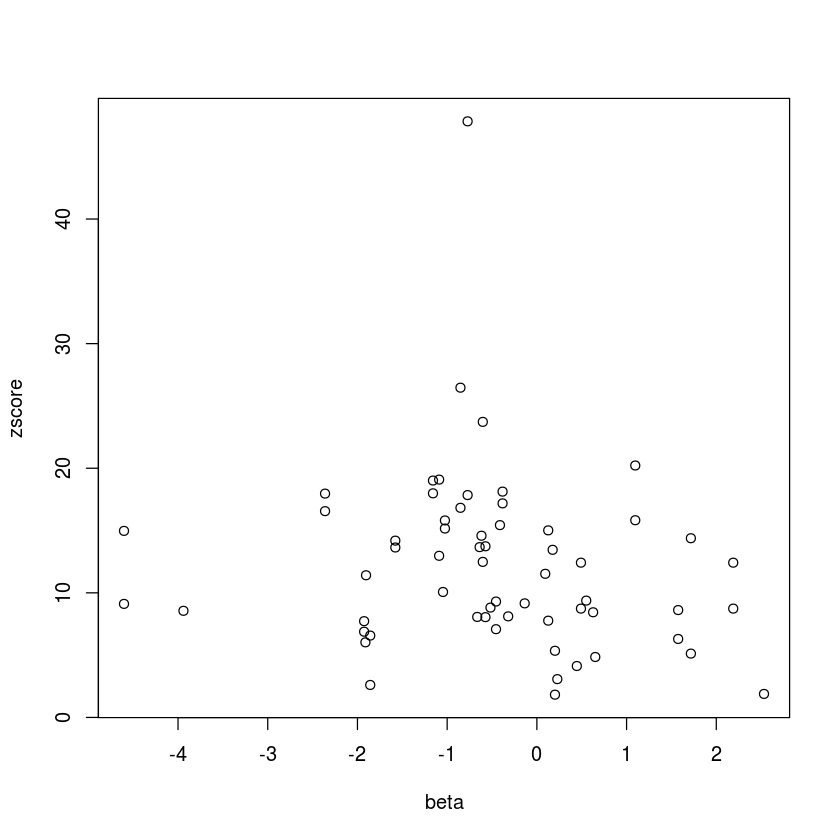

In [73]:
plot(zscore ~ beta, data = eclip2dif[ eclip2dif$cell_type == "cardiac_muscle",])

cor.test(eclip2dif[ eclip2dif$cell_type == "cardiac_muscle", "zscore"], eclip2dif[ eclip2dif$cell_type == "cardiac_muscle", "beta"])

In [37]:
str(eclip2gene)

List of 59
 $ CPEB4_K562   : chr [1:175] "ENSG00000157933.10_4" "ENSG00000173436.15_6" "ENSG00000158747.15_5" "ENSG00000270136.6_6" ...
 $ EIF4G2_K562  : chr [1:2831] "ENSG00000188157.15_6" "ENSG00000188157.15_6" "ENSG00000188157.15_6" "ENSG00000131591.17_10" ...
 $ EWSR1_K562   : chr [1:2746] "ENSG00000188976.11_5" "ENSG00000188157.15_6" "ENSG00000188157.15_6" "ENSG00000188157.15_6" ...
 $ FMR1_K562    : chr [1:1748] "ENSG00000188976.11_5" "ENSG00000188976.11_5" "ENSG00000127054.21_5" "ENSG00000127054.21_5" ...
 $ FUBP3_HepG2  : chr [1:1010] "ENSG00000188157.15_6" "ENSG00000242590.1_7" "ENSG00000157933.10_4" "ENSG00000116285.13_5" ...
 $ FUS_HepG2    : chr [1:4467] "ENSG00000188157.15_6" "ENSG00000188157.15_6" "ENSG00000188157.15_6" "ENSG00000078808.18_6" ...
 $ FUS_K562     : chr [1:6780] "ENSG00000187634.12_9" "ENSG00000188976.11_5" "ENSG00000187961.14_6" "ENSG00000187961.14_6" ...
 $ FXR2_HepG2   : chr [1:899] "ENSG00000107404.20_7" "ENSG00000225285.1_7" "ENSG00000189339.12_5" "ENS